In [74]:
import pandas as pd

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Auto-detect width
pd.set_option('display.max_colwidth', None) # Don't truncate long column values

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')


import os
os.environ["OMP_NUM_THREADS"] = "2"

### Data Cleaning

In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --------------------------
# Step 1: Load and inspect data
# --------------------------
hr_data = pd.read_csv('data/dataset/HR_data_2.csv', index_col=0)
RANDOM = 42

# Check initial missing values
missing_cols = hr_data.columns[hr_data.isna().any()]
missing_rows = hr_data[hr_data.isna().any(axis=1)]

print(f"There are {hr_data.isna().sum().sum()} missing values in the data.")
print("Missing columns:", missing_cols.tolist())
print("Rows with missing values:", missing_rows.index.tolist())

# --------------------------
# Step 2: Impute missing values with mode
# --------------------------
for col in missing_cols:
    mode_val = hr_data[col].mode()[0]
    hr_data[col].fillna(mode_val, inplace=True)

print(f"✅ Missing values imputed using mode. New shape: {hr_data.shape}")

# --------------------------
# Step 3: Clean and convert string-based categorical features
# --------------------------
hr_data['Round'] = hr_data['Round'].astype(str).apply(lambda x: int(x.split('_')[-1]))
hr_data['Phase'] = hr_data['Phase'].astype(str).apply(lambda x: int(x[-1]))

# --------------------------
# Step 4: One-hot encode categorical columns
# --------------------------
cat_cols = ['Cohort', 'Team_ID', 'Puzzler', 'Round', 'Phase', 'Individual']
hr_data_encoded = pd.get_dummies(hr_data, columns=cat_cols, dtype=np.int8)

# --------------------------
# Step 5: Drop irrelevant columns
# --------------------------
drop_cols = ['original_ID', 'raw_data_path']
hr_data_encoded.drop(columns=drop_cols, inplace=True, errors='ignore')

# --------------------------
# Step 6: Prepare numpy matrix for clustering
# --------------------------
if 'Unnamed: 0' in hr_data_encoded.columns:
    hr_data_encoded.drop(columns='Unnamed: 0', inplace=True)

clean_hr_df = hr_data_encoded.copy()
scaled_hr_df = StandardScaler().fit_transform(clean_hr_df)

print("✅ Data cleaned, imputed, and ready for clustering/PCA.")


There are 9 missing values in the data.
Missing columns: ['EDA_TD_P_RT', 'EDA_TD_P_ReT', 'inspired', 'attentive', 'afraid', 'active', 'determined']
Rows with missing values: [104, 120, 122, 125, 272]
✅ Missing values imputed using mode. New shape: (312, 70)
✅ Data cleaned, imputed, and ready for clustering/PCA.


### EDA

In [148]:
# Re-import required libraries after code execution state reset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal, chi2_contingency
from matplotlib import colors as mcolors
from itertools import combinations

sns.set(style="whitegrid")

# ---------- Step 1: Bar plots for categorical features ----------
def plot_counts(df, categorical_cols, ncols=3):
    n = len(categorical_cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'{col}')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# ---------- Step 2: Crosstab and Individual × Phase Heatmap ----------
def plot_individual_phase_heatmap(df):
    """
    Plots a heatmap of the number of observations per Phase × Individual with
    manually annotated cells that automatically adjust text color based on background.
"""
    ct = pd.crosstab(df['Phase'], df['Individual'])

    plt.figure(figsize=(8, 5))
    ax = sns.heatmap(
        ct,
        cmap='YlGnBu',
        cbar=False,
        linewidths=0.5,
        linecolor='gray'
    )

    # Get normalized color map to determine background color
    norm = plt.Normalize(ct.values.min(), ct.values.max())
    cmap = plt.get_cmap('YlGnBu')

    for y in range(ct.shape[0]):
        for x in range(ct.shape[1]):
            val = ct.iloc[y, x]
            bg_color = cmap(norm(val))
            luminance = mcolors.rgb_to_hsv(bg_color[:3])[2]  # brightness from HSV
            text_color = 'black' if luminance > 0.6 else 'white'
            ax.text(x + 0.5, y + 0.5, f'{val}',
                    ha='center', va='center', color=text_color, fontsize=9)

    ax.set_title("Observations per Phase by Individual")
    ax.set_xlabel("Individual")
    ax.set_ylabel("Phase")
    plt.tight_layout()
    plt.show()

# ---------- Step 3: Distribution Plots ----------
def plot_all_distributions(df, numeric_cols, ncols=4):
    n = len(numeric_cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=20)
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# ---------- Step 4: Correlation Heatmap ----------
def correlation_heatmap(df, cols):
    corr = df[cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        cmap='coolwarm',
        mask=mask,
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.7}
    )
    plt.title("Correlation Heatmap of Numeric Features")
    plt.tight_layout()
    plt.show()

# ---------- Step 5: Statistically Significant Scatter Plots ----------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

def kruskal_significant_heatmap(df, numeric_cols, ordinal_cols, alpha=0.05):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import kruskal

    # Compute p-values
    pvals = pd.DataFrame(index=ordinal_cols, columns=numeric_cols, dtype=float)

    for ord_col in ordinal_cols:
        for num_col in numeric_cols:
            try:
                groups = [group[num_col].dropna() for _, group in df.groupby(ord_col)]
                if all(len(g) > 1 for g in groups) and len(groups) > 1:
                    stat, p = kruskal(*groups)
                    pvals.loc[ord_col, num_col] = p
            except Exception:
                pvals.loc[ord_col, num_col] = np.nan

    # Mask where p >= alpha or NaN
    mask = (pvals >= alpha) | (pvals.isna())

    # Plot
    plt.figure(figsize=(len(numeric_cols) * 0.35, len(ordinal_cols) * 0.5))
    ax = sns.heatmap(
        pvals,
        mask=mask,
        cmap='coolwarm_r',
        annot=False,
        cbar_kws={'label': 'p-value'},
        linewidths=0.5,
        linecolor='gray'
    )

    # Manual annotations (only where p < alpha)
    for y in range(pvals.shape[0]):
        for x in range(pvals.shape[1]):
            if not mask.iloc[y, x]:
                p = pvals.iloc[y, x]
                ax.text(x + 0.5, y + 0.5, f"{p:.2g}",
                        ha='center', va='center', color='white' if p < 0.01 else 'black', fontsize=8)

    ax.set_title("Significant Kruskal-Wallis Results (Ordinal × Numeric)", fontsize=14)
    ax.set_xlabel("Numeric Features")
    ax.set_ylabel("Ordinal Features")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



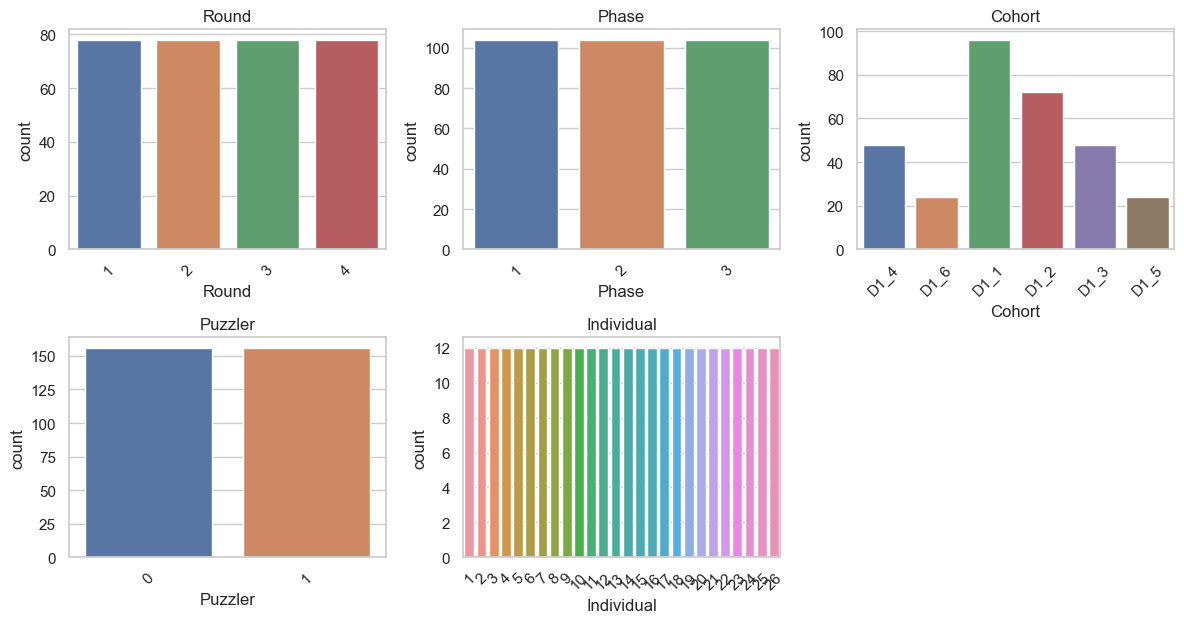

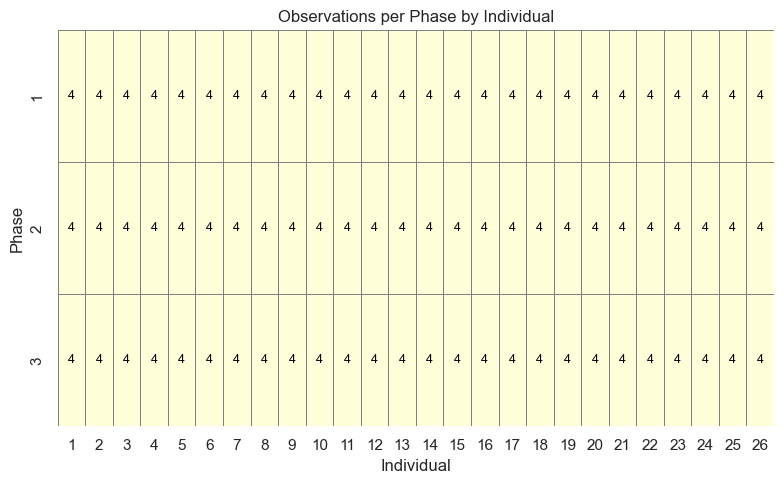

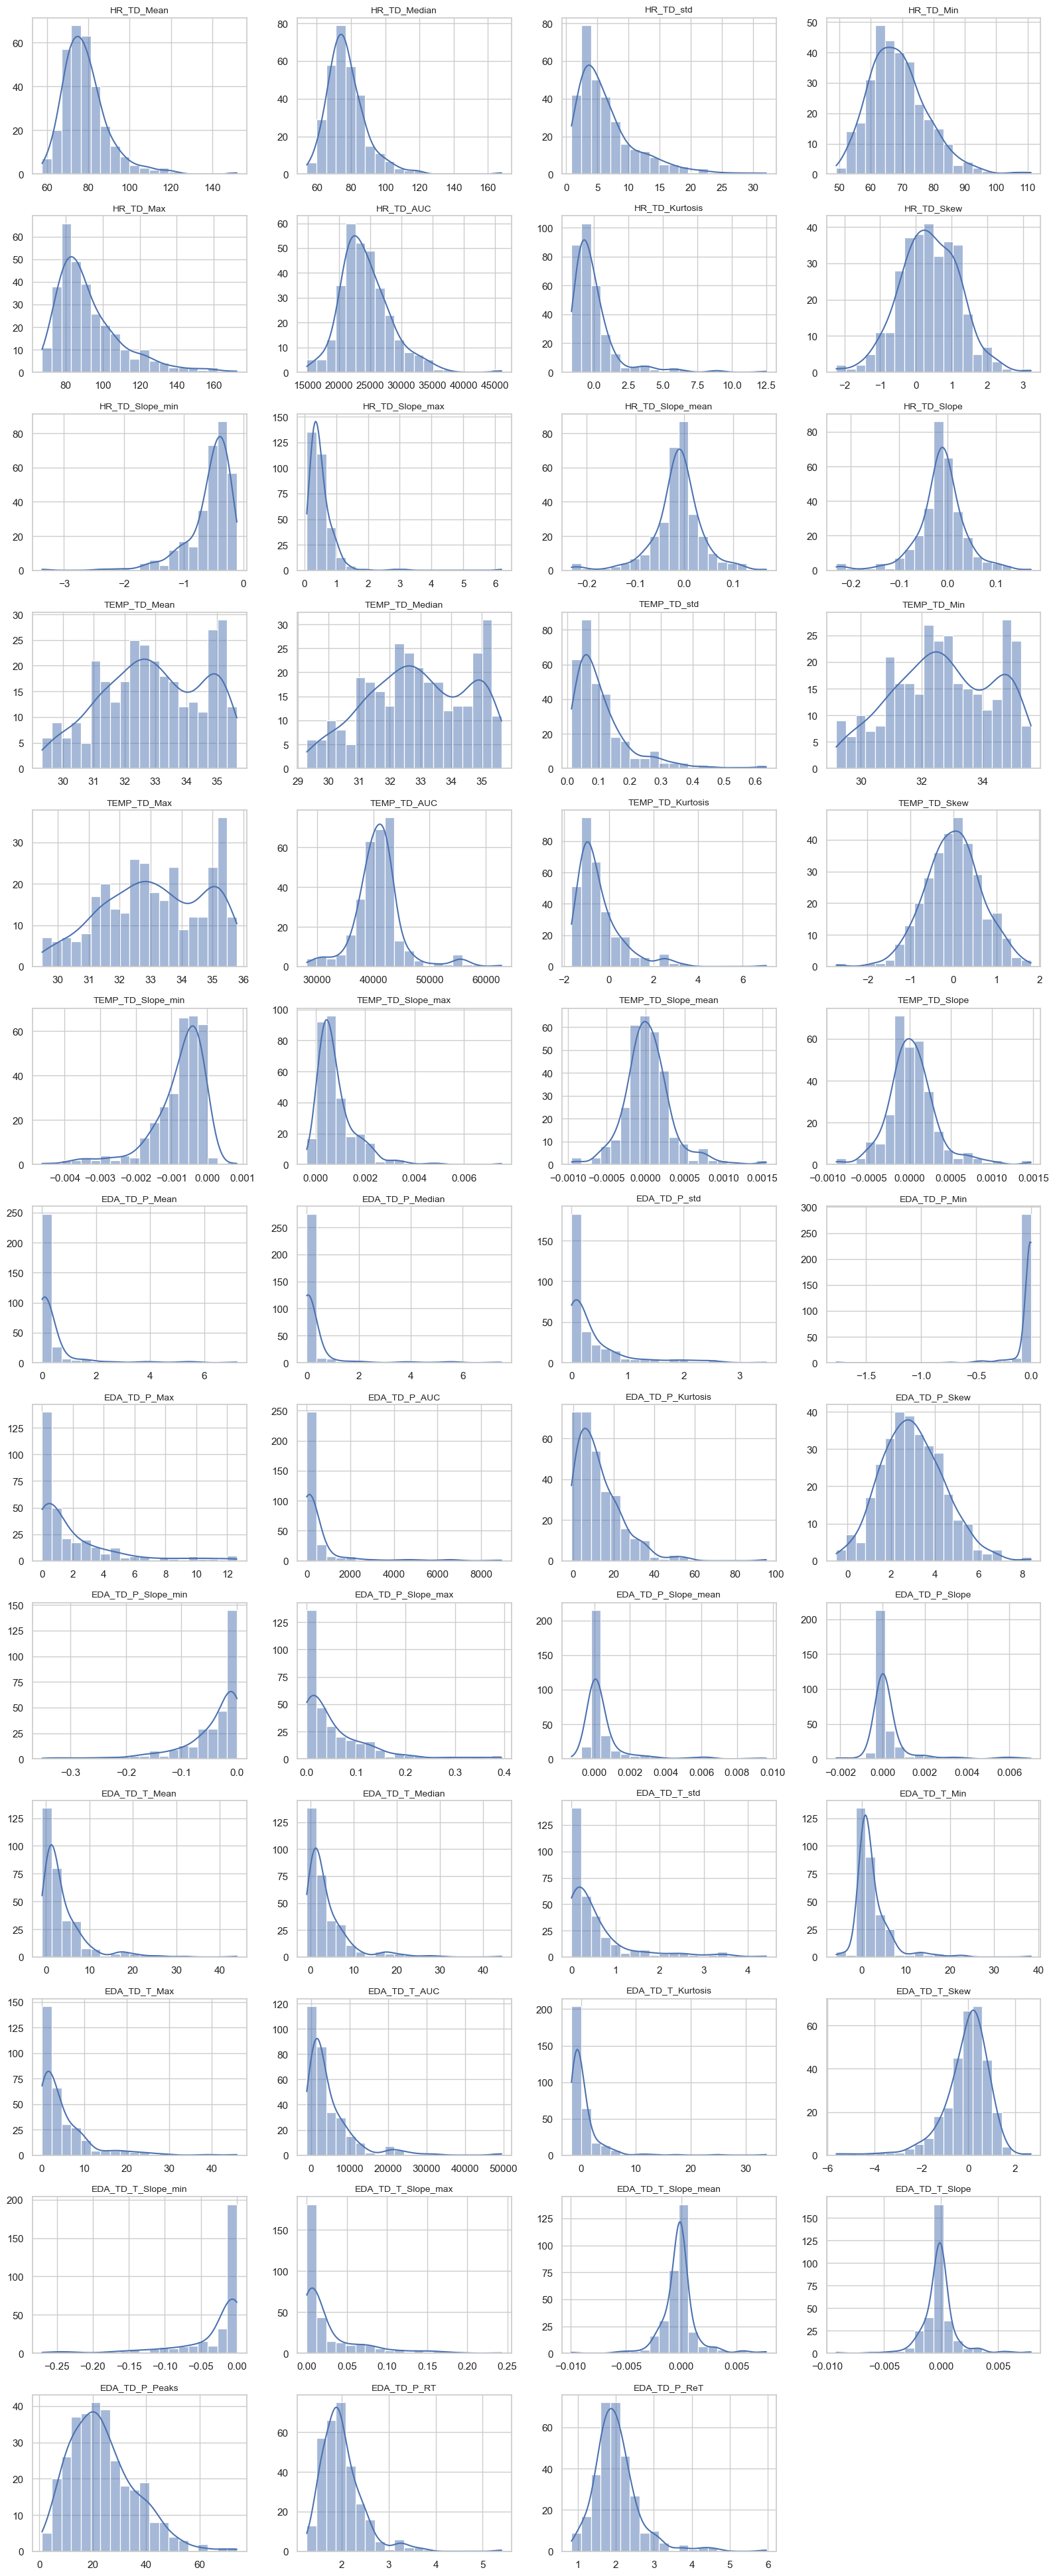

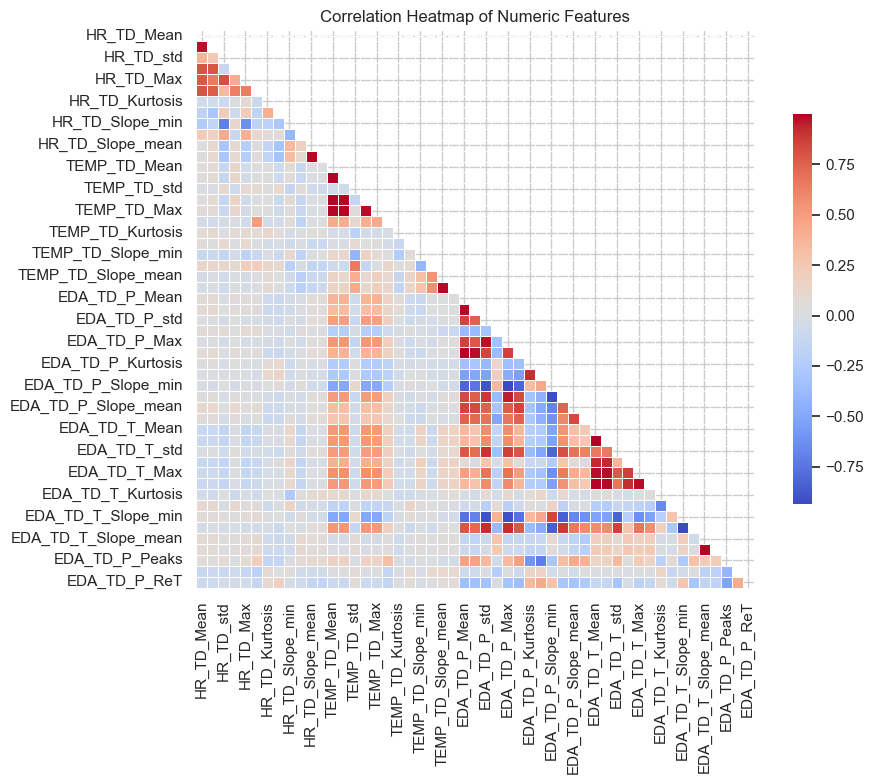

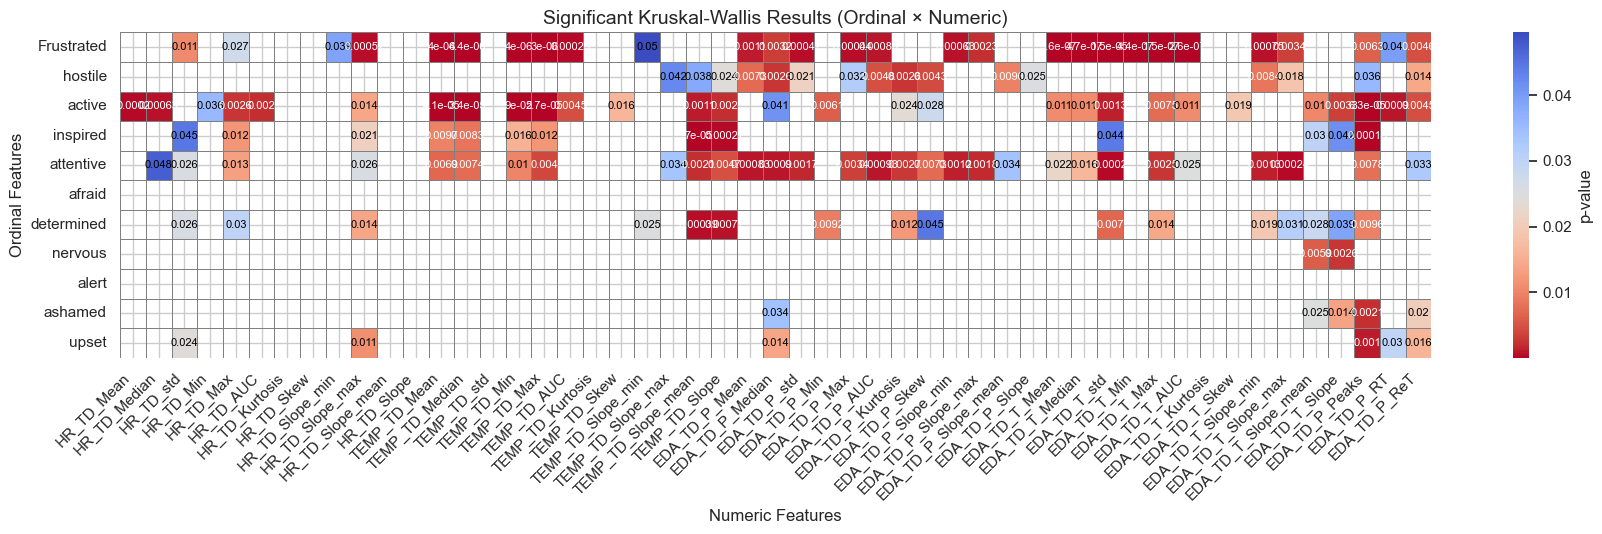

In [149]:
categorical_cols = ['Round', 'Phase', 'Cohort', 'Puzzler', 'Individual']
numeric_cols = [col for col in hr_data.columns if 'HR_' in col or 'EDA_' in col or 'TEMP_' in col]
ordinal_cols = ['Frustrated', 'hostile', 'active', 'inspired', 'attentive', 'afraid', 'determined', 'nervous', 'alert', 'ashamed', 'upset']
scatter_pairs_list = [('EDA_TD_P_AUC', 'Frustrated'), ('HR_TD_Mean', 'Frustrated')]

plot_counts(hr_data, categorical_cols)
plot_individual_phase_heatmap(hr_data)
plot_all_distributions(hr_data, numeric_cols)
correlation_heatmap(hr_data, numeric_cols)
kruskal_significant_heatmap(hr_data, numeric_cols, ordinal_cols)


### Exploring data through KMeans and visualizing through PCA

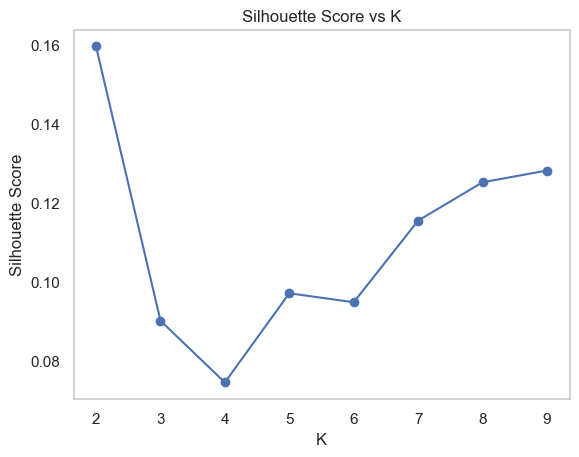

✅ Best K: 2


In [156]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try 2–15 clusters
scores = []
cluster_range = range(2, 10)
for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(scaled_hr_df)
    scores.append(silhouette_score(scaled_hr_df, labels))

# Plot Silhouette Score
plt.plot(cluster_range, scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Choose best K
best_k = cluster_range[np.argmax(scores)]
print("✅ Best K:", best_k)

# Assign final labels
final_model = KMeans(n_clusters=best_k, random_state=42)
hr_data['cluster_kmeans'] = final_model.fit_predict(scaled_hr_df)

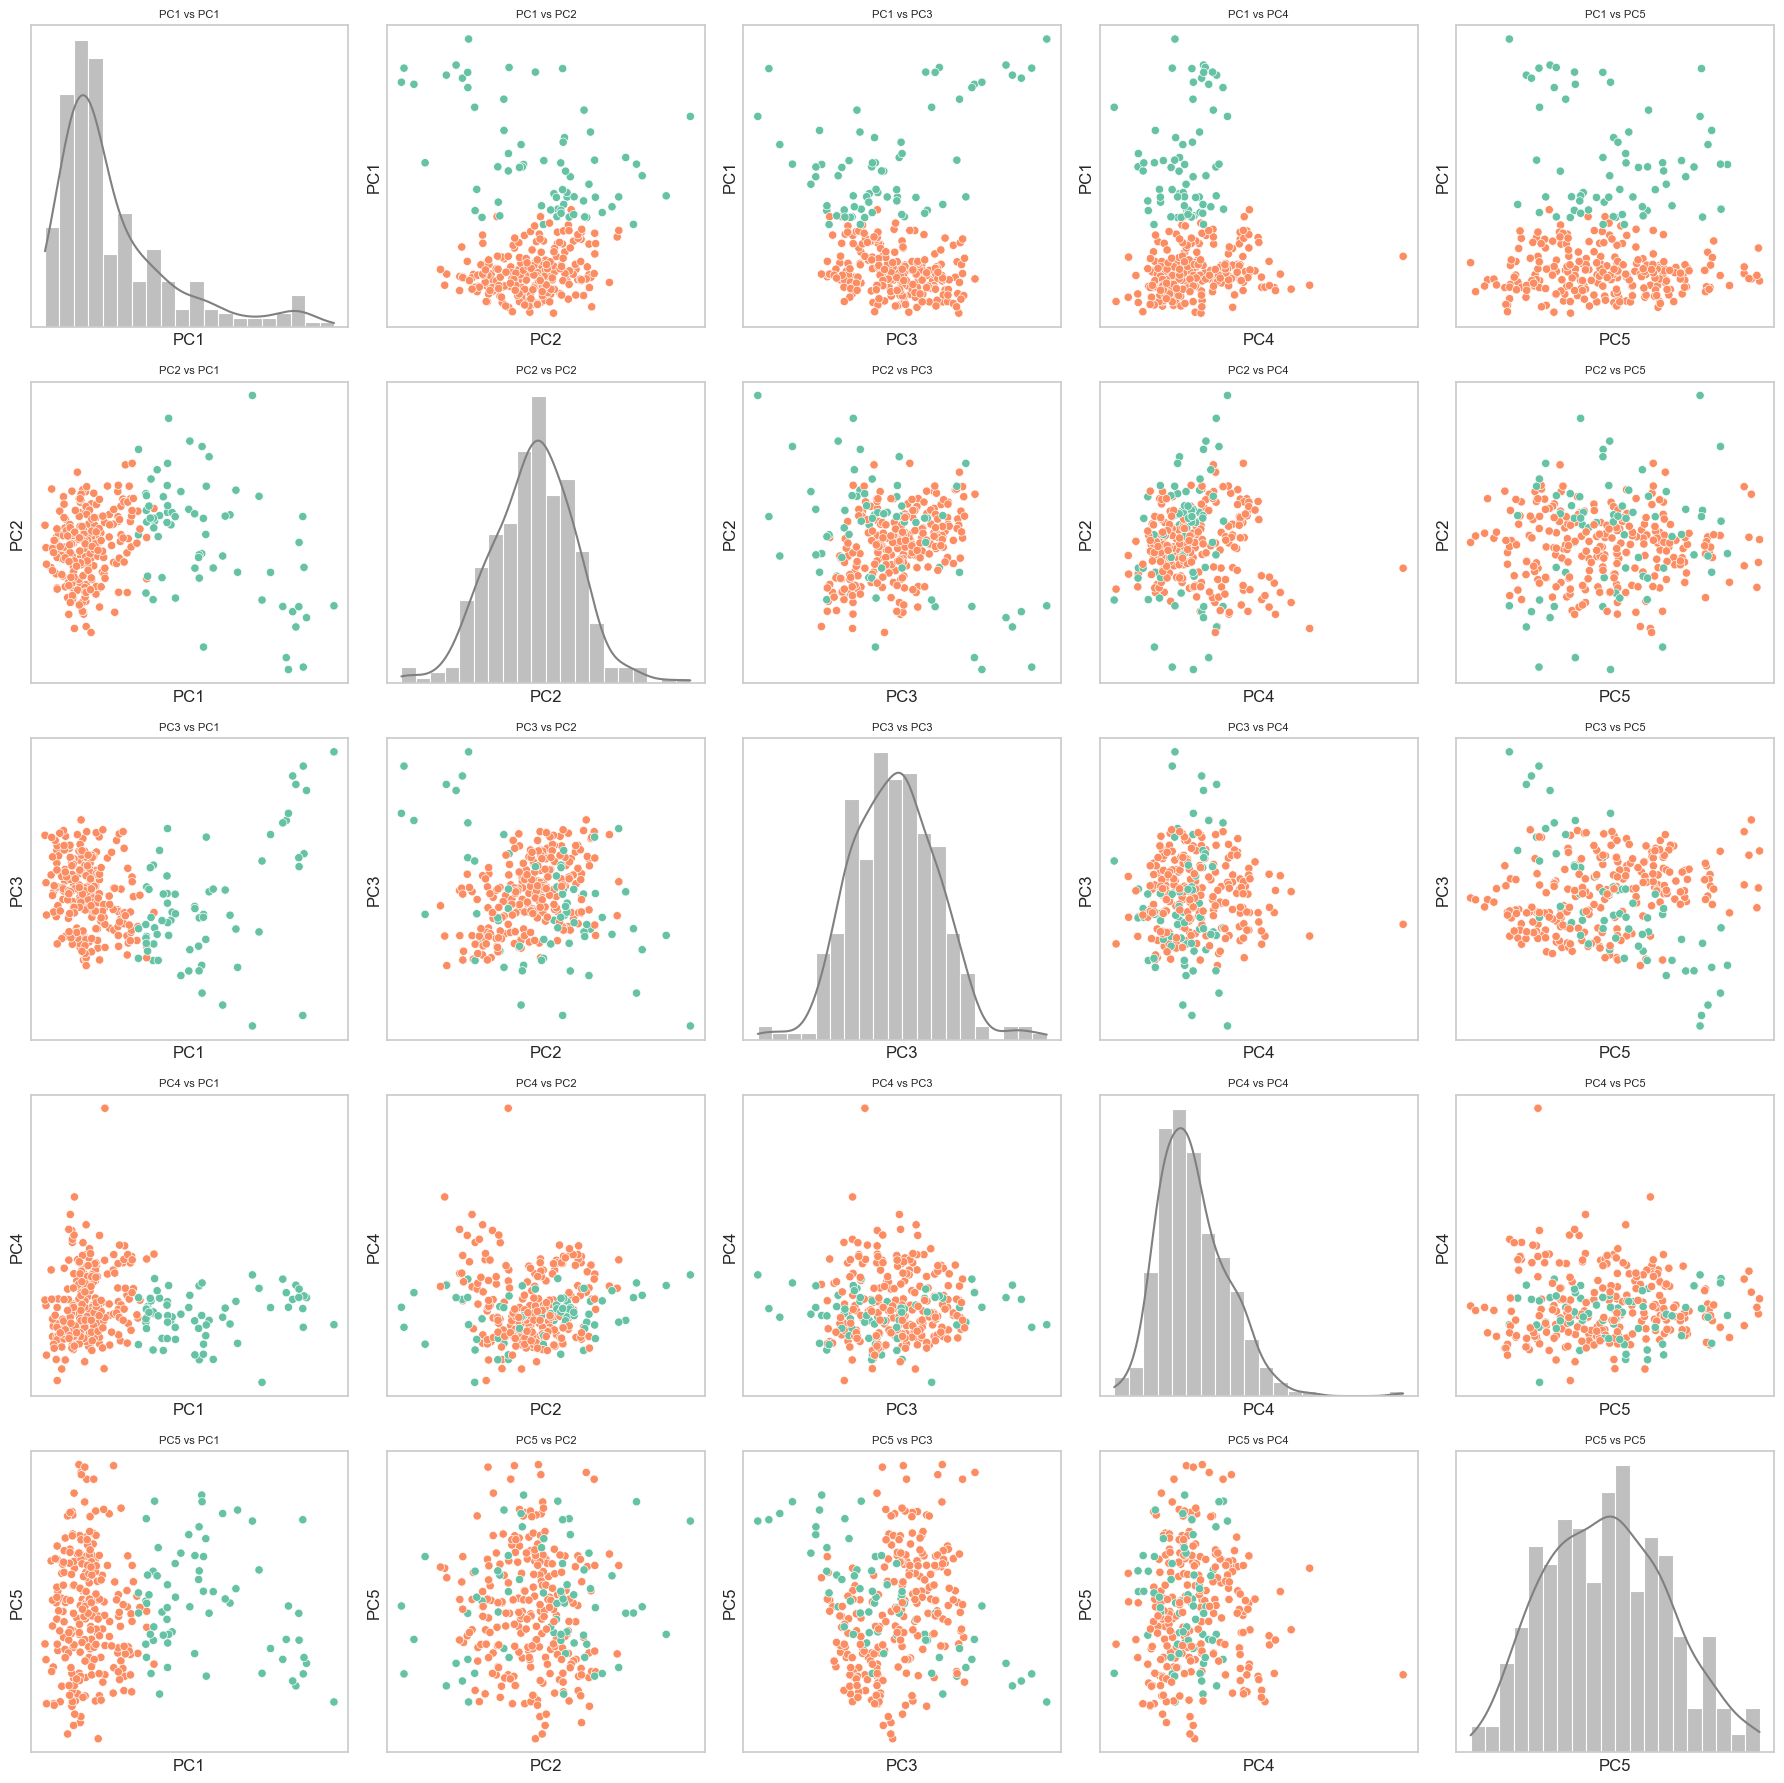

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assume scaled_hr_df and hr_data are already defined and include 'cluster_kmeans' column

# Run PCA with 5 components
pca = PCA(n_components=5)
pca_components = pca.fit_transform(scaled_hr_df)
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(5)])
pca_df['Cluster'] = hr_data['cluster_kmeans'].values

# Create a 5x5 grid of scatter plots for each PC combination
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i == j:
            # Diagonal: histogram of the PC
            sns.histplot(pca_df[f'PC{i+1}'], ax=ax, kde=True, bins=20, color='gray')
            ax.set_ylabel('')
            ax.set_xlabel(f'PC{i+1}')
        else:
            # Off-diagonal: scatter plot colored by cluster
            sns.scatterplot(data=pca_df, x=f'PC{j+1}', y=f'PC{i+1}', hue='Cluster', palette='Set2', ax=ax, legend=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'PC{i+1} vs PC{j+1}', fontsize=8)

plt.tight_layout()
plt.show()


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, chi2_contingency
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

# ------------------- STEP 0 -------------------
# Fit PCA (n_components=5) once globally for reuse
pca_model = PCA(n_components=5)
pca_components = pca_model.fit_transform(scaled_hr_df)
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(5)])
pca_df['Cluster'] = hr_data['cluster_kmeans'].values

# ------------------- STEP 1 -------------------
# Identify variables that are important in PC1 (from 5-PC model)

def get_top_pc1_features(pca_model, feature_names, top_n=25):
    pc1_loadings = pd.Series(pca_model.components_[0], index=feature_names)
    top_features = pc1_loadings.abs().sort_values(ascending=False).head(top_n)
    return top_features

# ------------------- STEP 2 -------------------
# Statistical differences in numerical features across clusters

def analyze_numerical_differences(df, numeric_cols, cluster_col='cluster_kmeans'):
    stats = []
    for col in numeric_cols:
        groups = [group[col].dropna() for _, group in df.groupby(cluster_col)]
        if all(len(g) > 1 for g in groups):
            stat, p = f_oneway(*groups)
            means = df.groupby(cluster_col)[col].mean()
            stds = df.groupby(cluster_col)[col].std()
            stats.append((col, p, *means.values, *stds.values))

    results = pd.DataFrame(stats, columns=['Feature', 'p_value'] +
                                        [f'Mean_Cluster{i}' for i in range(len(means))] +
                                        [f'Std_Cluster{i}' for i in range(len(means))])
    return results.sort_values('p_value')

# ------------------- STEP 3 -------------------
# Statistical differences in ordinal features across clusters

def analyze_ordinal_differences(df, ordinal_cols, cluster_col='cluster_kmeans'):
    stats = []
    for col in ordinal_cols:
        groups = [group[col].dropna() for _, group in df.groupby(cluster_col)]
        if all(len(g) > 1 for g in groups):
            stat, p = kruskal(*groups)
            means = df.groupby(cluster_col)[col].mean()
            stats.append((col, p, *means.values))

    results = pd.DataFrame(stats, columns=['Feature', 'p_value'] +
                                        [f'Mean_Cluster{i}' for i in range(len(means))])
    return results.sort_values('p_value')

# ------------------- STEP 4 -------------------
# Check cluster composition by Phase or Individual

def cluster_by_category(df, category_col, cluster_col='cluster_kmeans'):
    ct = pd.crosstab(df[category_col], df[cluster_col])
    ct_norm = ct.div(ct.sum(axis=1), axis=0)
    return ct, ct_norm

# ------------------- OPTIONAL -------------------
# Heatmap of PC1 top features

def plot_top_pc1_loadings(loadings):
    plt.figure(figsize=(8, 0.4 * len(loadings)))
    sns.barplot(x=loadings.values, y=loadings.index, palette='viridis')
    plt.title("Top Features Contributing to PC1")
    plt.xlabel("PC1 Loading")
    plt.tight_layout()
    plt.show()

# ------------------- HOW TO USE -------------------
# Example usage (replace lists as needed):
top_features = get_top_pc1_features(pca_model, clean_hr_df.columns, top_n=25)
#   plot_top_pc1_loadings(top_features)
numerical_stats = analyze_numerical_differences(hr_data, numeric_cols)
ordinal_stats = analyze_ordinal_differences(hr_data, ordinal_cols)
phase_ct, phase_ct_norm = cluster_by_category(hr_data, 'Phase')
indiv_ct, indiv_ct_norm = cluster_by_category(hr_data, 'Individual')


In [81]:
ordinal_stats

,Feature,p_value,Mean_Cluster0,Mean_Cluster1
3,inspired,0.035092,1.940299,2.248980
1,hostile,0.074845,1.104478,1.044898
2,active,0.082832,2.373134,2.600000
6,determined,0.153736,2.731343,2.963265
0,Frustrated,0.172221,1.820896,2.077551
8,alert,0.381488,2.104478,2.216327
5,afraid,0.415320,1.059701,1.048980
4,attentive,0.495796,2.701493,2.808163
9,ashamed,0.581195,1.253731,1.212245
10,upset,0.612380,1.388060,1.334694


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_combined_cluster_differences_with_pca(
    df, numerical_stats, ordinal_stats, scaled_data, feature_names, cluster_col='cluster_kmeans', alpha=0.05
):
    # Step 1: Significant features
    sig_num_df = numerical_stats[numerical_stats['p_value'] < alpha].copy()
    sig_ord_df = ordinal_stats[ordinal_stats['p_value'] < alpha].copy()

    sig_num_features = sig_num_df.sort_values('p_value')['Feature'].tolist()
    sig_ord_features = sig_ord_df.sort_values('p_value')['Feature'].tolist()
    all_sig_features = sig_num_features + sig_ord_features

    if not all_sig_features:
        print("No significant features found.")
        return None

    # Step 2: Add significance stars
    def starify(p):
        return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < alpha else ''

    sig_map = {**dict(zip(sig_num_df['Feature'], sig_num_df['p_value'])),
               **dict(zip(sig_ord_df['Feature'], sig_ord_df['p_value']))}
    
    annotated_labels = {
        feat: f"{feat} ({starify(sig_map[feat])} p={sig_map[feat]:.3g})"
        for feat in all_sig_features
    }

    # Step 3: Normalize data
    scaler = StandardScaler()
    scaled_vals = scaler.fit_transform(df[all_sig_features])
    scaled_df = pd.DataFrame(scaled_vals, columns=all_sig_features, index=df.index)
    scaled_df[cluster_col] = df[cluster_col]

    # Step 4: Prepare data for boxplots
    melted = scaled_df.melt(id_vars=cluster_col, var_name='Feature', value_name='Value')
    melted['Feature Annotated'] = melted['Feature'].map(annotated_labels)
    ordered_labels = [annotated_labels[f] for f in all_sig_features]

    # Step 5: Cohen's d (only for numeric)
    cohens_d_dict = {}
    for feat in sig_num_features:
        g0 = df[df[cluster_col] == 0][feat].dropna()
        g1 = df[df[cluster_col] == 1][feat].dropna()
        n0, n1 = len(g0), len(g1)
        s0, s1 = g0.std(), g1.std()
        s_pooled = np.sqrt(((n0 - 1)*s0**2 + (n1 - 1)*s1**2) / (n0 + n1 - 2))
        d = (g0.mean() - g1.mean()) / s_pooled
        cohens_d_dict[feat] = d
    cohens_d_series = pd.Series(cohens_d_dict).reindex(all_sig_features).fillna(0)
    cohens_d_series.index = ordered_labels

    # Step 6: PC1 Loadings
    pca = PCA()
    pca.fit(scaled_data)
    pc1_loadings = pd.Series(pca.components_[0], index=feature_names)
    pc1_loadings_filtered = pc1_loadings.reindex(all_sig_features).fillna(0)
    pc1_loadings_filtered.index = ordered_labels

    # Step 7: Plot
    fig, axes = plt.subplots(1, 3, figsize=(22, len(all_sig_features) * 0.45), gridspec_kw={'width_ratios': [1.5, 1, 1]})

    # Boxplot
    sns.boxplot(
        data=melted,
        x='Value',
        y='Feature Annotated',
        hue=cluster_col,
        orient='h',
        palette='Set2',
        order=ordered_labels,
        ax=axes[0]
    )
    axes[0].set_title("Boxplots of Significant Features (Standardized)")
    axes[0].set_xlabel("Standardized Value")
    axes[0].set_ylabel("Feature")
    axes[0].legend(title="Cluster", loc='lower right')

    # Cohen's d
    sns.barplot(
        x=cohens_d_series.values,
        y=cohens_d_series.index,
        palette='coolwarm',
        ax=axes[1]
    )
    axes[1].set_title("Cohen's d (Effect Size)")
    axes[1].set_xlabel("Cohen's d")
    axes[1].set_yticklabels([])  # remove variable names
    axes[1].set_ylabel("")
    axes[1].axvline(0, color='gray', linestyle='--')

    # PCA loadings
    sns.barplot(
        x=pc1_loadings_filtered.values,
        y=pc1_loadings_filtered.index,
        palette='viridis',
        ax=axes[2]
    )
    axes[2].set_title("PC1 Loadings")
    axes[2].set_xlabel("Loading Value")
    axes[2].set_yticklabels([])  # remove variable names
    axes[2].set_ylabel("")
    axes[2].axvline(0, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()

    return cohens_d_series, pc1_loadings_filtered


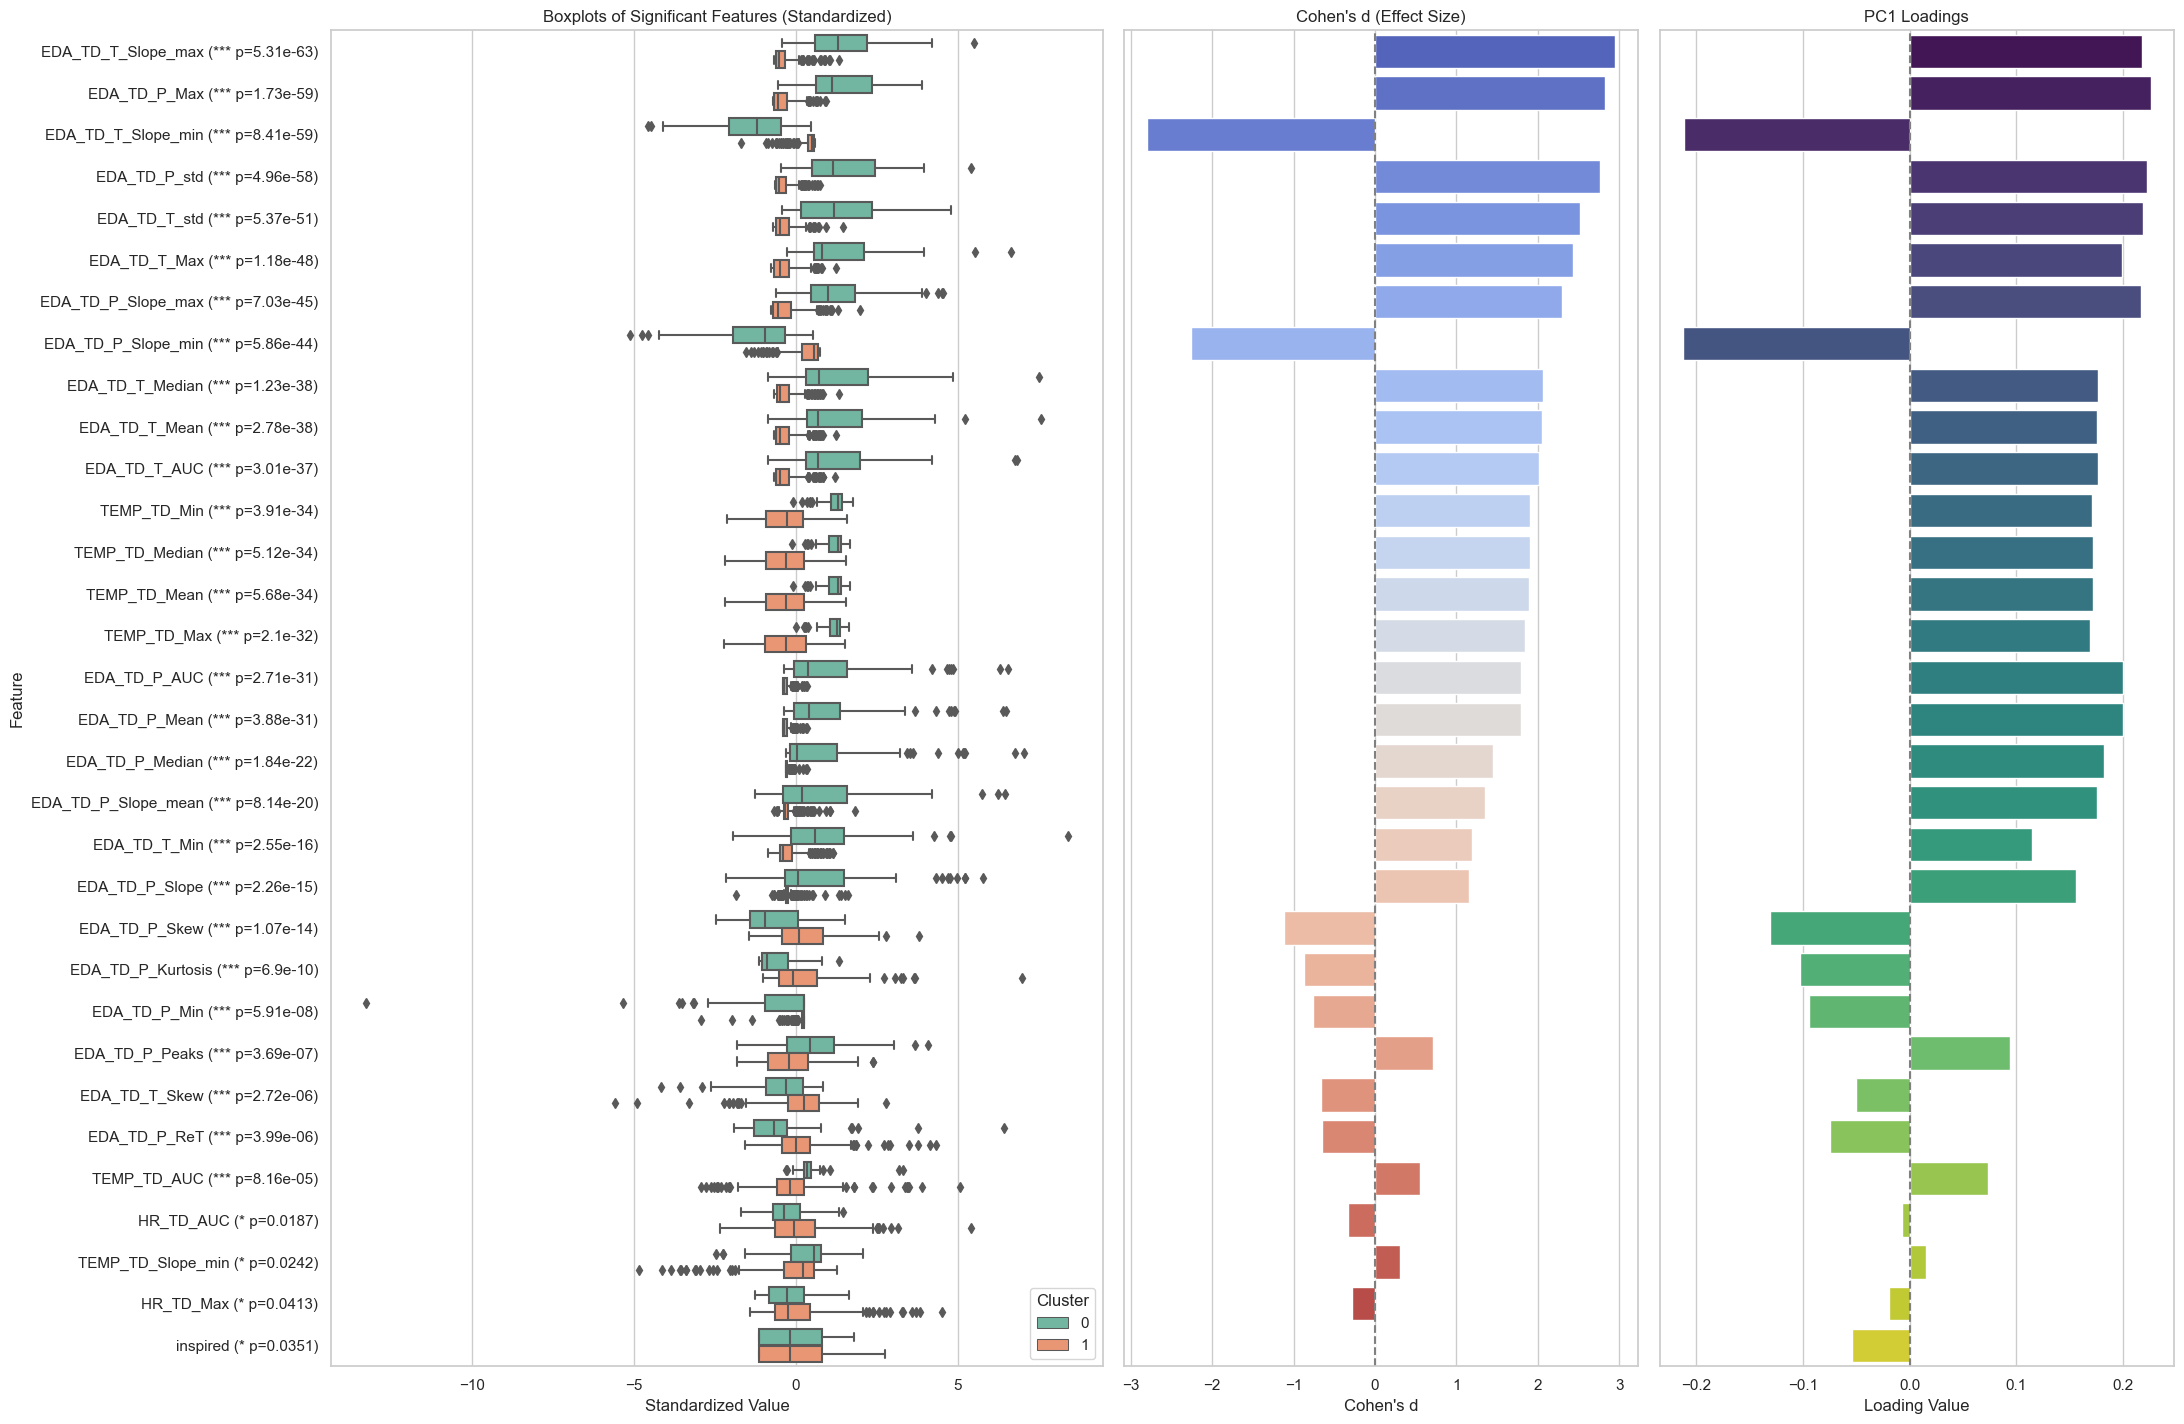

In [83]:
cohens_d, pc1_loadings = plot_combined_cluster_differences_with_pca(
    hr_data, numerical_stats, ordinal_stats,
    scaled_data=scaled_hr_df,  # your PCA input
    feature_names=clean_hr_df.columns,  # original feature names
    cluster_col='cluster_kmeans'
)


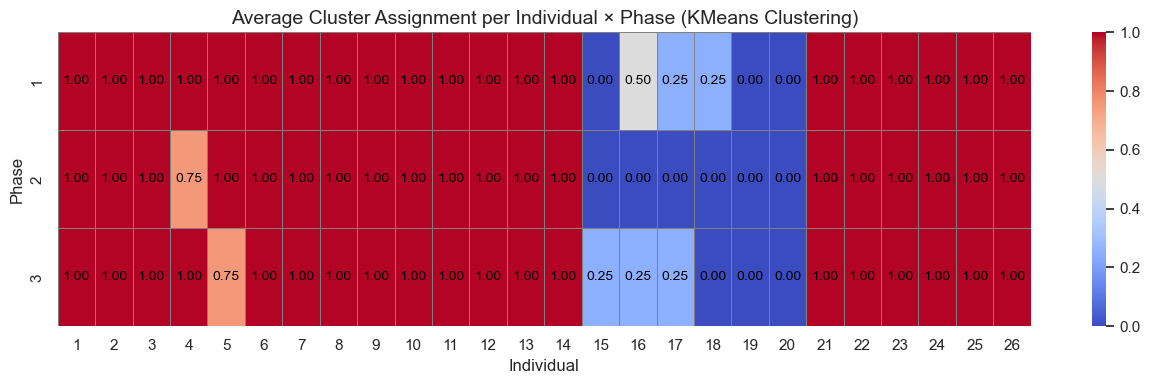

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the average cluster label per Individual × Phase
cluster_avg = hr_data.groupby(['Phase', 'Individual'])['cluster_kmeans'].mean().unstack()

# Plot
plt.figure(figsize=(13, 4))
ax = sns.heatmap(
    cluster_avg,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Manual annotations (rounded average)
for y in range(cluster_avg.shape[0]):
    for x in range(cluster_avg.shape[1]):
        val = cluster_avg.iloc[y, x]
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center', color='black', fontsize=10)

# Titles and labels
ax.set_title("Average Cluster Assignment per Individual × Phase (KMeans Clustering)", fontsize=14)
ax.set_xlabel("Individual")
ax.set_ylabel("Phase")
plt.tight_layout()
plt.show()


In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway

def theme_based_composite_analysis_with_pvals_and_stars(df, cluster_col='cluster_kmeans', alpha=0.05):
    """
    Computes theme-wise z-score composites, plots their distributions across clusters
    with annotated p-values and significance stars.
    """

    # --- 1. Define variable groups (themes) ---
    themes = {
    # Physiological themes
    "Arousal (EDA)": [col for col in df.columns if 'EDA' in col and not any(s in col for s in ['Skew', 'Kurtosis'])],
    "Temperature": [col for col in df.columns if 'TEMP' in col],
    "Heart Rate": [col for col in df.columns if 'HR' in col],
    "Stress Shape (Skew/Kurtosis)": [col for col in df.columns if 'Skew' in col or 'Kurtosis' in col],
    "Slope Features": [col for col in df.columns if 'Slope' in col],
    "Peak/Count Features": [col for col in df.columns if 'Peaks' in col or 'ReT' in col],

    # Emotion-based (ordinal) themes based on PANAS
    "Positive Emotions": ['active', 'alert', 'attentive', 'determined', 'inspired'],
    "Negative Emotions": ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']
    }


    # --- 2. Standardize all numeric features used in themes ---
    feature_cols = sum(themes.values(), [])
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df[feature_cols])
    scaled_df = pd.DataFrame(scaled_values, columns=feature_cols, index=df.index)

    # --- 3. Compute composite z-scores ---
    for theme, cols in themes.items():
        df[f'{theme}_z'] = scaled_df[cols].mean(axis=1)

    z_score_cols = [f'{t}_z' for t in themes.keys()]

    # --- 4. Melt for seaborn ---
    melted = df[[cluster_col] + z_score_cols].melt(id_vars=cluster_col, var_name='Theme', value_name='Z-score')
    melted['Theme'] = melted['Theme'].str.replace('_z', '', regex=False)

    # --- 5. Compute p-values between clusters ---
    pval_map = {}
    star_map = {}
    for theme in themes.keys():
        values = df[[cluster_col, f'{theme}_z']].dropna()
        groups = [group[f'{theme}_z'] for _, group in values.groupby(cluster_col)]
        if all(len(g) > 1 for g in groups):
            stat, p = f_oneway(*groups)
            pval_map[theme] = p
            star_map[theme] = (
                '***' if p < 0.001 else
                '**' if p < 0.01 else
                '*' if p < alpha else ''
            )

    # --- 6. Sort themes by p-value for visual clarity ---
    sorted_themes = sorted(pval_map.keys(), key=lambda k: pval_map[k])
    melted['Theme'] = pd.Categorical(melted['Theme'], categories=sorted_themes, ordered=True)

    # --- 7. Plot with annotated p-values and stars ---
    plt.figure(figsize=(10, 0.9 * len(themes)))
    ax = sns.boxplot(data=melted, x='Z-score', y='Theme', hue=cluster_col, orient='h', palette='Set2')

    for i, theme in enumerate(sorted_themes):
        p = pval_map[theme]
        sig = star_map[theme]
        label = f"p = {p:.3g} {sig}"
        ax.text(1.02, i, label, transform=ax.get_yaxis_transform(), va='center', fontsize=10, color='black')

    plt.title("Hierarchical - Composite Theme Z-Scores by Cluster (with p-values and significance stars)")
    plt.xlabel("Average Standardized Score")
    plt.ylabel("Physiological Theme")
    plt.legend(title="Cluster", bbox_to_anchor=(1.3, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


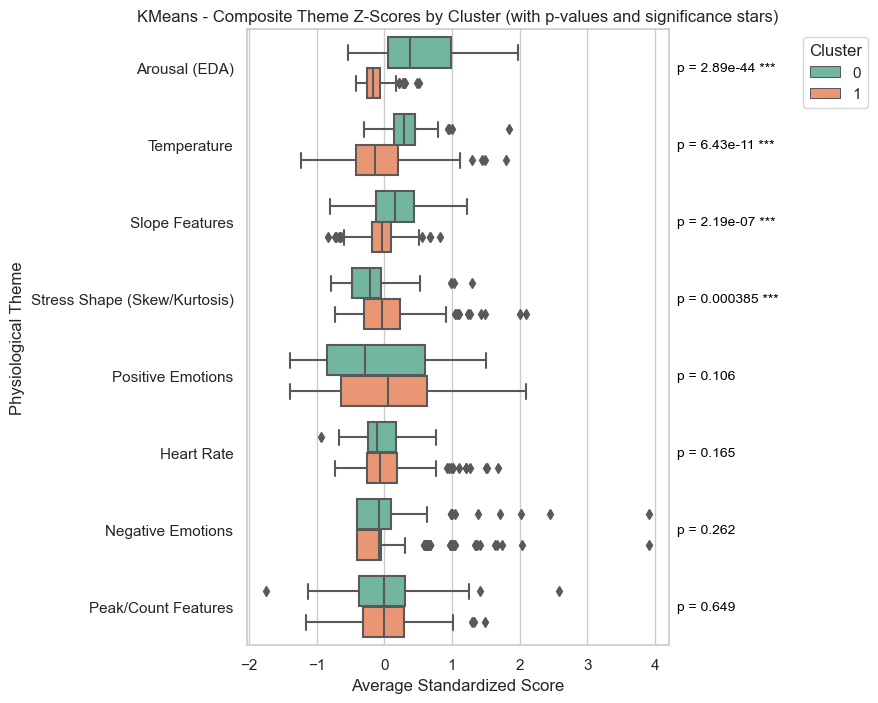

In [131]:
theme_based_composite_analysis_with_pvals_and_stars(hr_data, cluster_col='cluster_kmeans')


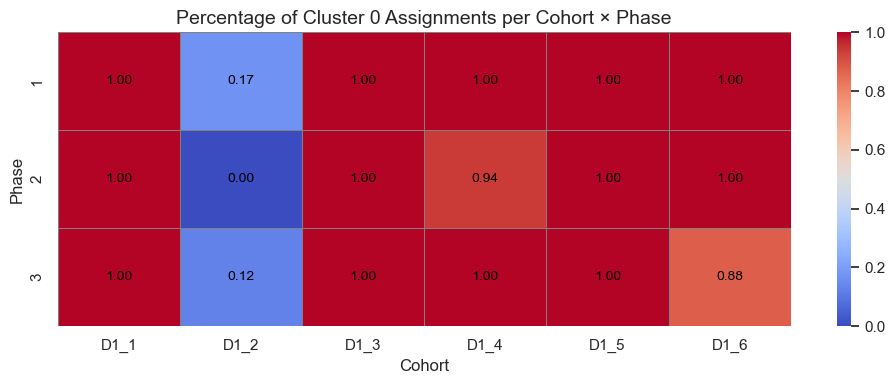

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute % of times each cohort was in cluster 0 for each phase
cluster_pct_cohort = hr_data.groupby(['Phase', 'Cohort'])['cluster_kmeans'].mean().unstack()

# Plot
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    cluster_pct_cohort,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Manual annotations
for y in range(cluster_pct_cohort.shape[0]):
    for x in range(cluster_pct_cohort.shape[1]):
        val = cluster_pct_cohort.iloc[y, x]
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center', color='black', fontsize=10)

# Titles and labels
ax.set_title("Percentage of Cluster 0 Assignments per Cohort × Phase", fontsize=14)
ax.set_xlabel("Cohort")
ax.set_ylabel("Phase")
plt.tight_layout()
plt.show()


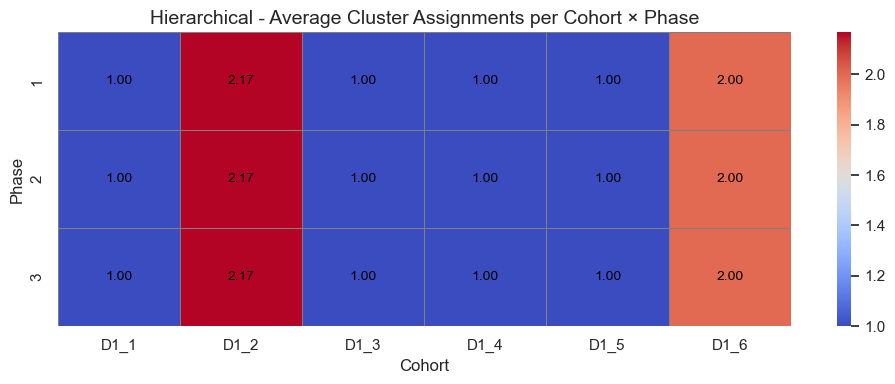

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute % of times each cohort was in cluster 0 for each phase
cluster_pct_cohort = hr_data.groupby(['Phase', 'Cohort'])['cluster_hierarchical'].mean().unstack()

# Plot
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    cluster_pct_cohort,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Manual annotations
for y in range(cluster_pct_cohort.shape[0]):
    for x in range(cluster_pct_cohort.shape[1]):
        val = cluster_pct_cohort.iloc[y, x]
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center', color='black', fontsize=10)

# Titles and labels
ax.set_title("Hierarchical - Average Cluster Assignments per Cohort × Phase", fontsize=14)
ax.set_xlabel("Cohort")
ax.set_ylabel("Phase")
plt.tight_layout()
plt.show()


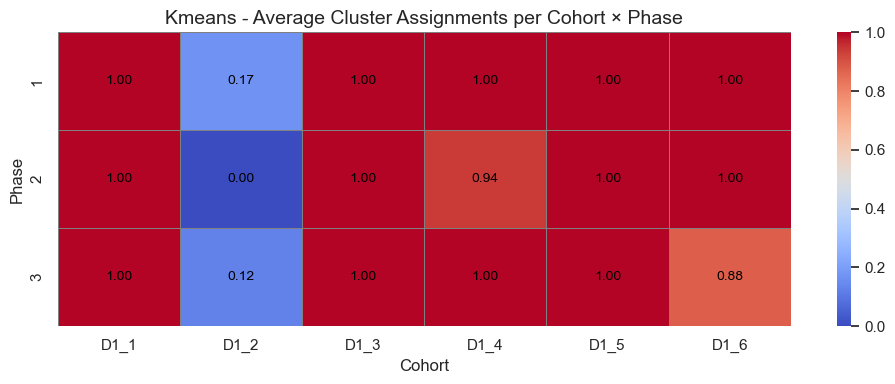

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute % of times each cohort was in cluster 0 for each phase
cluster_pct_cohort = hr_data.groupby(['Phase', 'Cohort'])['cluster_kmeans'].mean().unstack()

# Plot
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    cluster_pct_cohort,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Manual annotations
for y in range(cluster_pct_cohort.shape[0]):
    for x in range(cluster_pct_cohort.shape[1]):
        val = cluster_pct_cohort.iloc[y, x]
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center', color='black', fontsize=10)

# Titles and labels
ax.set_title("Kmeans - Average Cluster Assignments per Cohort × Phase", fontsize=14)
ax.set_xlabel("Cohort")
ax.set_ylabel("Phase")
plt.tight_layout()
plt.show()


In [157]:
from sklearn.mixture import GaussianMixture

#### Labeling clusters ####
# Choose the best k based on internal validation metrics
Best_k = 2  # You can change this to use another metric's recommendation

# K-MEANS
# Using K-means clustering with the selected number of clusters
# cluster_pca = KMeans(n_clusters=Best_k, random_state=RANDOM)
# cluster_labels_pca = cluster_pca.fit_predict(scaled_data)

# GMM
cluster_labels_pca = GaussianMixture(n_components=Best_k, 
                            covariance_type="full", # TODO: tied?
                            reg_covar=0.01,
                            random_state=RANDOM)
cluster_labels_pca = cluster_labels_pca.fit_predict(scaled_hr_df)


# Add cluster labels to the original data
hr_data['cluster_gmm'] = cluster_labels_pca
pd.crosstab(hr_data['cluster_kmeans'], hr_data['cluster_gmm'], rownames=['KMeans'], colnames=['GMM'])

GMM,0,1
KMeans,,
0,67,0
1,8,237


In [154]:
#### Hierarchical clustering ####
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
# Parameters for clustering
d_sample = 'euclidean'  # Sample distance metric
d_group = 'ward'  # Linkage method
N_leafs = scaled_hr_df.shape[0]

# Perform hierarchical clustering
Z = linkage(scaled_hr_df, method=d_group, metric=d_sample, optimal_ordering=True)

# Calculate cophenetic correlation coefficient to evaluate clustering quality
c, coph_dists = cophenet(Z, pdist(scaled_hr_df, metric=d_sample))
print(f"Cophenetic correlation coefficient: {c:.3f} (closer to 1 is better)")

from scipy.cluster.hierarchy import fcluster

# Assign 3 clusters from the dendrogram
hr_data['cluster_hierarchical'] = fcluster(Z, t=3, criterion='maxclust')

#pd.crosstab(hr_data['cluster_kmeans'], hr_data['cluster_hierarchical'], rownames=['KMeans'], colnames=['Hierarchical'])


Cophenetic correlation coefficient: 0.513 (closer to 1 is better)


In [158]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_gmm = adjusted_rand_score(hr_data['cluster_kmeans'], hr_data['cluster_gmm'])
nmi_gmm = normalized_mutual_info_score(hr_data['cluster_kmeans'], hr_data['cluster_gmm'])

ari_hier = adjusted_rand_score(hr_data['cluster_kmeans'], hr_data['cluster_hierarchical'])
nmi_hier = normalized_mutual_info_score(hr_data['cluster_kmeans'], hr_data['cluster_hierarchical'])

print(f"GMM - ARI: {ari_gmm:.3f}, NMI: {nmi_gmm:.3f}")
print(f"Hierarchical - ARI: {ari_hier:.3f}, NMI: {nmi_hier:.3f}")


GMM - ARI: 0.890, NMI: 0.818
Hierarchical - ARI: 0.616, NMI: 0.517


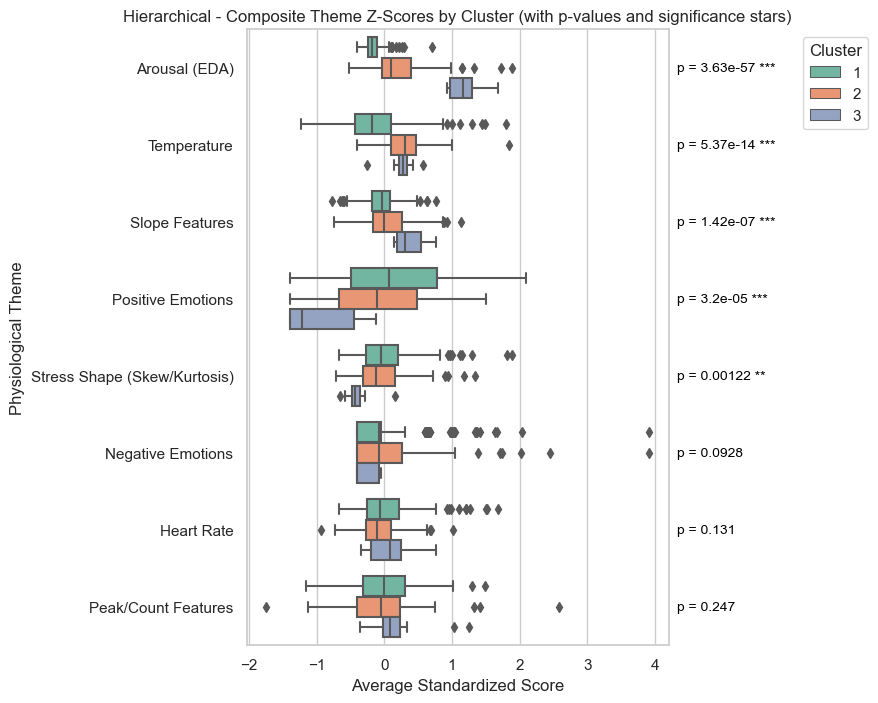

In [159]:
theme_based_composite_analysis_with_pvals_and_stars(hr_data, cluster_col='cluster_hierarchical')


In [139]:
numerical_stats_hier

,Feature,p_value,Mean_Cluster0,Mean_Cluster1,Mean_Cluster2,Std_Cluster0,Std_Cluster1,Std_Cluster2
24,EDA_TD_P_Mean,1.308459e-112,8.381958e-02,0.624961,4.983507,0.156872,0.691815,1.335553
25,EDA_TD_P_Median,5.776354e-110,3.961899e-02,0.380039,4.834683,0.115085,0.600311,1.684353
29,EDA_TD_P_AUC,4.625644e-108,1.049161e+02,780.551725,6065.943565,197.016650,893.554963,1641.867928
28,EDA_TD_P_Max,2.673676e-81,7.256328e-01,3.903399,11.028846,0.911076,2.460464,1.419732
33,EDA_TD_P_Slope_max,2.430929e-76,2.324481e-02,0.107217,0.300047,0.027970,0.062516,0.077868
26,EDA_TD_P_std,1.928170e-72,1.197844e-01,0.725596,2.273570,0.166994,0.566828,0.496016
32,EDA_TD_P_Slope_min,5.503945e-71,-1.754082e-02,-0.085029,-0.235214,0.021588,0.053109,0.074571
34,EDA_TD_P_Slope_mean,2.401566e-70,1.548812e-04,0.000693,0.006083,0.000370,0.001282,0.002238
45,EDA_TD_T_Slope_max,1.423187e-63,9.620645e-03,0.052239,0.147955,0.013529,0.039872,0.040832
38,EDA_TD_T_std,2.733687e-62,2.289724e-01,1.080824,3.072410,0.268622,0.851808,0.710547


In [160]:
alpha = 0.05

numerical_stats_kmeans = analyze_numerical_differences(hr_data, numeric_cols, cluster_col='cluster_kmeans')
numerical_stats_gmm = analyze_numerical_differences(hr_data, numeric_cols, cluster_col='cluster_gmm')
numerical_stats_hier = analyze_numerical_differences(hr_data, numeric_cols, cluster_col='cluster_hierarchical')




# Get sets of significant features
sig_kmeans = set(numerical_stats_kmeans[numerical_stats_kmeans['p_value'] < alpha]['Feature'])
sig_gmm = set(numerical_stats_gmm[numerical_stats_gmm['p_value'] < alpha]['Feature'])
sig_hier = set(numerical_stats_hier[numerical_stats_hier['p_value'] < alpha]['Feature'])

# Shared across all three
common_all = sig_kmeans & sig_gmm & sig_hier

# Unique to each method
unique_kmeans = sig_kmeans - (sig_gmm | sig_hier)
unique_gmm = sig_gmm - (sig_kmeans | sig_hier)
unique_hier = sig_hier - (sig_kmeans | sig_gmm)

# Shared between pairs
kmeans_and_gmm = sig_kmeans & sig_gmm
kmeans_and_hier = sig_kmeans & sig_hier
gmm_and_hier = sig_gmm & sig_hier

all_features = sorted(sig_kmeans | sig_gmm | sig_hier)
comparison_df = pd.DataFrame({
    'Feature': all_features,
    'KMeans': [f in sig_kmeans for f in all_features],
    'GMM': [f in sig_gmm for f in all_features],
    'Hierarchical': [f in sig_hier for f in all_features]
})

comparison_df

,Feature,KMeans,GMM,Hierarchical
0,EDA_TD_P_AUC,True,True,True
1,EDA_TD_P_Kurtosis,True,True,True
2,EDA_TD_P_Max,True,True,True
3,EDA_TD_P_Mean,True,True,True
4,EDA_TD_P_Median,True,True,True
5,EDA_TD_P_Min,True,True,True
6,EDA_TD_P_Peaks,True,True,True
7,EDA_TD_P_ReT,True,True,True
8,EDA_TD_P_Skew,True,True,True
9,EDA_TD_P_Slope,True,True,True


In [ ]:
from sklearn.mixture import GaussianMixture

#### Labeling clusters ####
# Choose the best k based on internal validation metrics
Best_k = 2  # You can change this to use another metric's recommendation

# K-MEANS
# Using K-means clustering with the selected number of clusters
# cluster_pca = KMeans(n_clusters=Best_k, random_state=RANDOM)
# cluster_labels_pca = cluster_pca.fit_predict(scaled_data)

# GMM
cluster_labels_pca = GaussianMixture(n_components=Best_k, 
                            covariance_type="full", # TODO: tied?
                            reg_covar=0.01,
                            random_state=RANDOM)
cluster_labels_pca = cluster_labels_pca.fit_predict(scaled_hr_df)


# Add cluster labels to the original data
hr_data['cluster_gmm'] = cluster_labels_pca
pd.crosstab(hr_data['cluster_kmeans'], hr_data['cluster_gmm'], rownames=['KMeans'], colnames=['GMM'])

GMM,0,1
KMeans,,
0,67,0
1,8,237


C:\Users\vidis\AppData\Local\Temp\ipykernel_20636\2818880473.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


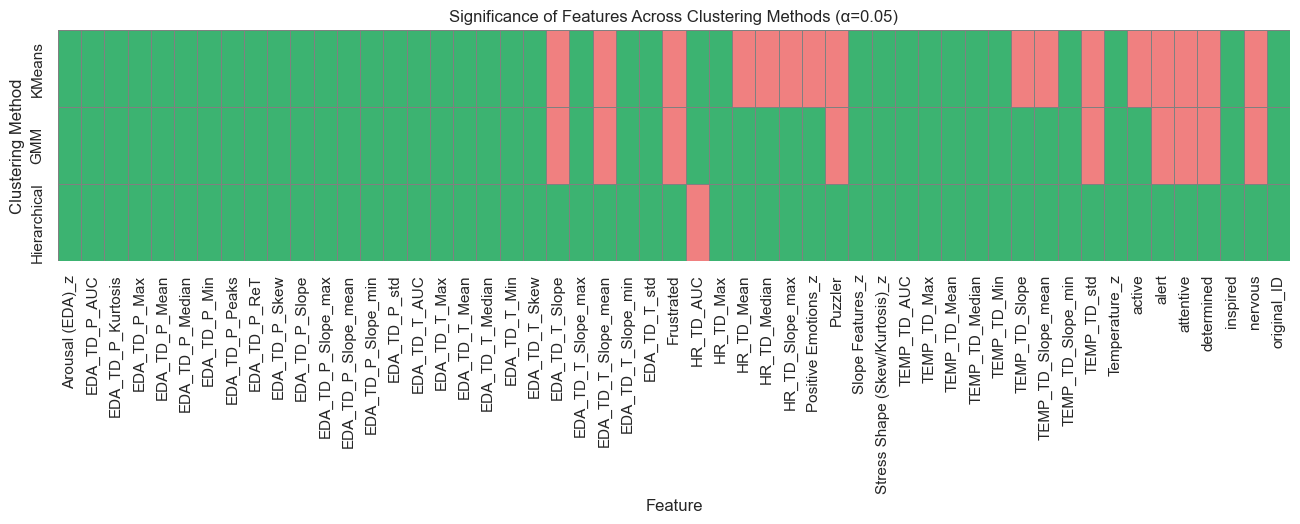

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal

def get_significant_features(df, feature_cols, ordinal_cols, cluster_col, alpha=0.05):
    significant = set()

    for col in feature_cols:
        try:
            groups = [g[col].dropna() for _, g in df.groupby(cluster_col)]
            if len(groups) >= 2 and all(len(g) > 1 for g in groups):
                stat, p = f_oneway(*groups) if col not in ordinal_cols else kruskal(*groups)
                if p < alpha:
                    significant.add(col)
        except:
            continue
    return significant

# Define columns
ordinal_cols = ['active', 'alert', 'attentive', 'determined', 'inspired',
                'afraid', 'ashamed', 'hostile', 'nervous', 'upset']
feature_cols = [c for c in hr_data.columns if c not in ['cluster_kmeans', 'cluster_gmm', 'cluster_hierarchical', 'Cohort', 'Phase', 'Individual'] and hr_data[c].dtype != 'object']

# Get significant features
sig_kmeans = get_significant_features(hr_data, feature_cols, ordinal_cols, 'cluster_kmeans')
sig_gmm = get_significant_features(hr_data, feature_cols, ordinal_cols, 'cluster_gmm')
sig_hier = get_significant_features(hr_data, feature_cols, ordinal_cols, 'cluster_hierarchical')

# Combine all features
all_features = sorted(set(sig_kmeans | sig_gmm | sig_hier))

# Create presence matrix
sig_matrix = pd.DataFrame({
    'KMeans': [f in sig_kmeans for f in all_features],
    'GMM': [f in sig_gmm for f in all_features],
    'Hierarchical': [f in sig_hier for f in all_features],
}, index=all_features).T

# Plot heatmap
plt.figure(figsize=(len(all_features) * 0.3, 3))
sns.heatmap(sig_matrix, cmap=sns.color_palette(['lightcoral', 'mediumseagreen']),
            cbar=False, linewidths=0.5, linecolor='gray', xticklabels=True)

plt.title("Significance of Features Across Clustering Methods (α=0.05)")
plt.xlabel("Feature")
plt.ylabel("Clustering Method")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


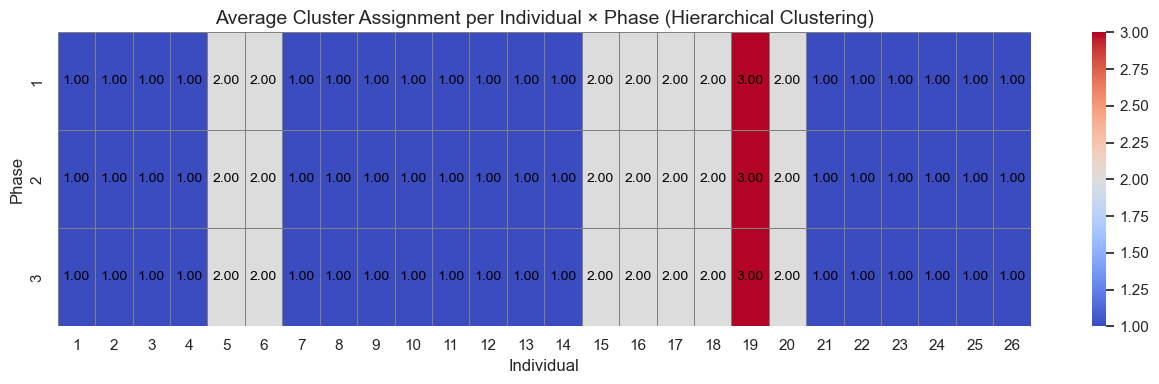

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the average cluster label per Individual × Phase
cluster_avg = hr_data.groupby(['Phase', 'Individual'])['cluster_hierarchical'].mean().unstack()

# Plot
plt.figure(figsize=(13, 4))
ax = sns.heatmap(
    cluster_avg,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Manual annotations (rounded average)
for y in range(cluster_avg.shape[0]):
    for x in range(cluster_avg.shape[1]):
        val = cluster_avg.iloc[y, x]
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center', color='black', fontsize=10)

# Titles and labels
ax.set_title("Average Cluster Assignment per Individual × Phase (Hierarchical Clustering)", fontsize=14)
ax.set_xlabel("Individual")
ax.set_ylabel("Phase")
plt.tight_layout()
plt.show()
